# **TBRC Data Simulator**
Author: Michael Kainola

Date: August 1, 2022

This notebook demonstrates the key steps of the TBRC Data Simulator. This applications accepts a cleaned sample dataset from the TBRC as an input and outputs a configurable number of simulated datasets, based on the original input.

<br>

**Step 1. Load the external dependencies.**

In [1]:
import csv #for reading csv files
from matplotlib import pyplot as plt #for visualizing results
import numpy as np #for randomizing data
import random
import copy #for using deepcopy
import statistics

<br>

**Step 2. Define application parameters.**

In [2]:
dup_percent = 20 #% chance of duplicating a data point
drop_percent = 20 #% chance of dropping a data point
samples = 20 # number of datasets to generate

<br>

**Step 3.1 Define function for duplicating values.**

In [3]:
# function to duplicate values; probability of duplication dictated by dup_percent application parameter
def dupCheck(d1,d2,ind):
    
    # random chance to duplicate a value
    chance = random.randint(0,100) 
    
    # if chance variable is greater than 100 - dup_percent, perform duplication
    if chance > 100 - dup_percent:
                
        # get value to be duplicated
        val1 = d1[ind] #luminosity
        val2 = d2[ind] #temperature
        
        # duplicate it
        d1.insert(ind,val1)
        d2.insert(ind,val2)
        
        # increase duplication counter
        dup_counter = 1

    # otherwise, do not perform duplication
    else:
        dup_counter = 0
    
    return dup_counter # return count of duplicates

<br>

**Step 3.2 Define function for dropping values.**

In [4]:
# function to drop values; probability of drop dictated by drop_percent application parameter
def dropCheck(d1,d2,ind):

    # random chance to drop a value
    chance = random.randint(0,100) 

    # if chance variable is greater than 100 - drop_percent, perform drop
    if chance > 100 - drop_percent:
        
        # drop the values via list.pop()
        d1.pop(ind) #luminosity
        d2.pop(ind) #temperature
        
        # increment drop counter
        drop_counter = 1

    # otherwise, do not perform duplication
    else:
        drop_counter = 0
    
    return drop_counter # return count of drops

<br>

**Step 3.3 Define function for smoothing values.**

The transformation applied to the dataset tend to generate a lot of noise in the data; the following function smoothes this data using binning.

In [5]:
# function to smooth the dataset using binning
def smooth(d, binsize):
    
    # binsize = 2
    size = len(d)
    
    # loop through data, perform binning
    for x in range(0,size,binsize):
    
        z = 0
        bin = []    
    
        # add the values to the bin
        while z < binsize and x + z < size:    
            bin.append(d[x + z])
            z += 1
    
        # calculate the mean of the bin
        avg = statistics.mean(bin)

        z = 0
        
        # write the mean back to list 'd'
        while z < binsize and x + z < size:    
            d[x + z] = avg
            z += 1
    
    return d # return the smoothed data

<br>

**Step 3.4 Define function for running all the transformations to the dataset.**

In [6]:
# function to apply all the transformation (duplication values, droping values, randomizing values, etc.)
# accepts two datasets representing the brightness and temperature datasets
def mutate(d1, d2):
    
    factor = round(np.random.uniform(-0.04,0.04),2) # for adjusting the global tendency of the data
    dup_counter = 0 # tracking number of duplicates
    drop_counter = 0 # tracking number of drops
    
    # duplicate values - loop multiple times
    for q in range(3):
        for ind,_ in enumerate(d1):
            dup_counter += dupCheck(d1,d2,ind)

    # drop values - loop multiple times
    for q in range(4):
        for ind,_ in enumerate(d1):
            drop_counter += dropCheck(d1,d2,ind)
    
    # adjust the entire tendency of the dataset slightly based on 'factor' parameter above
    for ind,_ in enumerate(d1):
        
        #calculate new values
        v1 = d1[ind] * (1 - factor)
        v2 = d2[ind] * (1 - factor)

        #update lists
        d1[ind] = v1
        d2[ind] = v2
        
    # apply random adjustment to each value
    for ind,_ in enumerate(d1):
        
        #generate random %
        r = np.random.uniform(-0.02, 0.02)
        
        #apply random factor to both vals     
        v1 = d1[ind] + d1[ind] * r
        v2 = d2[ind] + d2[ind] * r
        
        #update lists
        d1[ind] = v1
        d2[ind] = v2
    
    #smooth out the datasets
    d1 = smooth(d1,2)
    d2 = smooth(d2,2)
    
    #returns both datasets
    return d1, d2

<br>

**Step 3.5 Define functions for reading from and writing to CSV.**

In [7]:
# function to read the cleaned sample dataset from the TBRC
def readCSV(filename):
    x = 1
    
    # open reader
    with open(filename, newline='') as f:
        
        reader = csv.reader(f)
        
        #skip the header
        next(reader)

        # create list of lists
        data = [[],[],[]]
        
        # store the csv data in list of lists
        for row in reader:
            data[0].append(x)
            data[1].append(float(row[1]))
            data[2].append(float(row[2]))
            x += 1 

    return data[1], data[2] # return the luminosity and temperature data

# function to create csv files containing the simulated datasets
def createCSV(d1,d2):
    
    # folder to store the data
    folder = 'SimData/'
    
    # loop through the dataset
    for x in range(len(d1)):
        
        # define headers
        fields = ['Index', 'Brightness', 'Temperature']  
               
        r1 = d1[x]
        r2 = d2[x]

        # write the data to csv
        with open(folder + 'Sim' + str(x) + '.csv', 'w', newline='') as f: 
            write = csv.writer(f) 
            
            # write header row
            write.writerow(fields) 
            
            # write the data rows
            for i,_ in enumerate(r1):
                
                # build the row
                z = []
                z.append(i)
                z.append(r1[i])
                z.append(r2[i])
                
                #write the row
                write.writerow(z) 

<br>

**Step 3.6 Define functions for visualizing the simulated data.**

Visualizes both the original input dataset and the newly simulated datasets, for comparison.

In [8]:
# function to visualize the results of the simulation process.
def vizdatagrid(m1,m2, rows, cols):
    
    # define the grid
    rows = 4
    cols = 3
    cmap = plt.cm.get_cmap('hsv', rows*cols) # create color map for visualizing the results 

    # define the plot and its dimensions
    fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True)
    fig.suptitle('Simulated process data (Temperature and Luminosity)')
    fig.tight_layout(h_pad=1)
    fig.set_figheight(8)
    fig.set_figwidth(12)
    

    z = 0
    
    # loop through the rows
    for x in range(rows):
        
        # loop through the cols
        for y in range (cols):
            
            # plot the data
            axs[x,y].plot(m1[z], c=cmap(z), label="orig")        
            axs[x,y].plot(m2[z], c=cmap(z), label="orig")        
            
            # set the title (original vs simulation)
            if z == 0:
                axs[x, y].set_title('Original')
            else:
                axs[x, y].set_title('Simulation' + str(z))
            
            # set the subplot style
            axs[x,y].grid(b=True, which='major', color='#666666', linestyle='-')
            axs[x,y].minorticks_on()
            axs[x,y].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
            z += 1
    
    #show the plot
    plt.show()


<br>

**Step 4. Import input data.**

In [9]:
# import the cleaned datasets (d1 = luminosity; d2 = temperature )
d1, d2 = readCSV('Inputs/data_clean.csv')

# 
mut1 = [] # list of simulated luminosity datasets
mut2 = [] # list of simulated temperature datasets

#append the ORIGINAL datasets, for vizualization purposes
mut1.append(d1)
mut2.append(d2)

<br>

**Step 5. Perform simulation.**

In [10]:
# perform simulation N number of times, based on 'samples' parameter
for x in range(samples):
    
    # create deepcopies of datasets (shallow copy maintains reference to original dataset and causes issues)
    d1_copy = copy.deepcopy(d1)
    d2_copy = copy.deepcopy(d2)
    
    # pass the deepcopies to the mutation function, store the returned simulated datasets
    m1, m2 = mutate(d1_copy, d2_copy)
    
    # add the SIMULATED dataset to list for visualization purposes
    mut1.append(m1)
    mut2.append(m2)

<br>

**Step 6. Visualize the simulated data.**

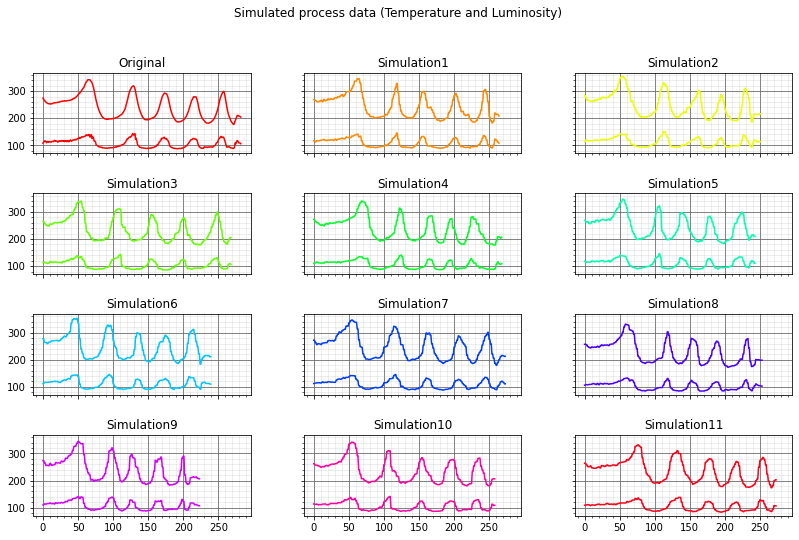

In [11]:
# visualize the results
vizdatagrid(mut1,mut2,3,4)

<br>

**Step 7. Save the simulated data.**

In [12]:
# store the simulated datasets in CSV (in SimData folder); one file for each simulation
createCSV(mut1,mut2)